In [2]:
import os
import cv2
import numpy as np

spectrograms = []
labels = []

# dossier = "./dataset/data/ordered_clips/"


# def read_files(folder, folder_name):
#     for file in os.listdir(folder):
#         file_path = os.path.join(folder, file)
#         file_ = cv2.imread(file_path)

#         if(file_ is not None):
#             spectrograms.append(file_)
#             labels.append(folder_name)
        
# for nom_fichier in os.listdir(dossier):
#     chemin_fichier = os.path.join(dossier, nom_fichier)

#     # Vérifier si l'élément est un dossier
#     if os.path.isdir(chemin_fichier):
#         read_files(chemin_fichier, nom_fichier)

# print(spectrograms[0].shape)

In [8]:
import librosa

def extract_features(row):
    clips_path = "./dataset/data/clips/"
    clip_path = clips_path + row.path + ".mp3"
    features = {}
    
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(clip_path) 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    features["mfccs"] = mfccs

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    features["stft"] = stft

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features["chroma"] = chroma

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
    features["mel"] = mel

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    features["contrast"] = contrast

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    features["tonnetz"] = tonnetz        
    
    if(row.gender == "male"): row.gender = 1
    else: row.gender = 0


    print("mfccs:", mfccs)
    print("stft:", stft)
    print("chroma:", chroma)
    print("mel:", mel)
    print("contrast:", contrast)
    print("tonnetz:", tonnetz)
    
    # * columns: client_id, path, age, gender, mfccs, stft, chroma, mel, contract, tonnetz 
    data = [row.client_id, row.gender, mfccs, stft, chroma, mel, contrast, tonnetz]
    return data

In [9]:
def audio_pipeline(row):  
  clips_path = "./dataset/data/clips/"
  clip_path = clips_path + row.path + ".mp3"
  features = {}

  # Loads the audio file as a floating point time series and assigns the default sample rate
  # Sample rate is set to 22050 by default
  audio, sample_rate = librosa.load(clip_path) 

  if(row.gender == "male"): row.gender = 1
  else: row.gender = 0

  features = []

  features.append(row["client_id"])
  features.append(row["gender"])
  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCCs
  mfccs = librosa.feature.mfcc(y=audio)
  # print("mfccs len:", len(mfccs))

  for x in mfccs:
    features.append(np.mean(x))



  return features

# Read dataset


## rename client id

In [16]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

dataframe = pd.read_table("./dataset/train.tsv")
dataframe = dataframe.drop(columns=["up_votes", "accent", "sentence", "down_votes"])

client_ids = dataframe.groupby(["client_id"]).sum().reset_index()["client_id"].tolist()
new_client_id = [x for x in range(len(client_ids) + 1)]

def rename_client(row):
    return client_ids.index(row["client_id"])

# * Rename client_id
dataframe["client_id"] = dataframe.apply(rename_client, axis=1)

print(dataframe["client_id"])

0        48
1        48
2        48
3        48
4        48
         ..
18933    58
18934    58
18935    58
18936    58
18937    58
Name: client_id, Length: 18938, dtype: int64


# Data filtering

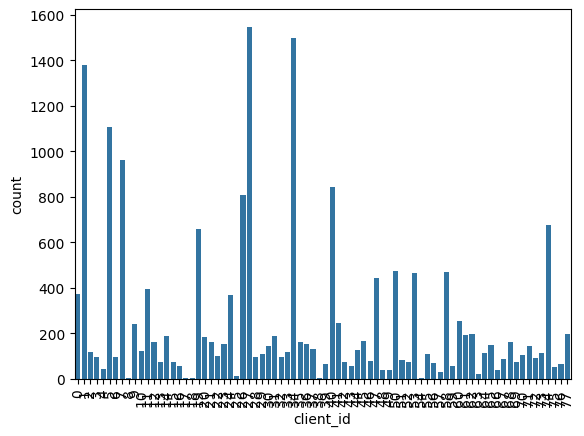

In [11]:
sns.countplot(x=dataframe["client_id"]) # plot the categories
plt.xticks(rotation=90);

In [24]:
print(dataframe.query("client_id == 1"))

       client_id                                               path       age  \
17090          1  1f0193f454471d950810b7935d712b45ae4f5ddad735a8...  fourties   
17091          1  b206709c8b8bf975dfa01ed9fadf578418a9a5670a9a77...  fourties   
17092          1  8eab9439c5fed9fe692ebfad57974203d1ae2f9aeffdab...  fourties   
17093          1  c37120ccb46cf34bb65c478ed75466b6bbf5024873a132...  fourties   
17094          1  ea4cff95f58cf1d3037149cf0b3eb461dbcc8851039a7e...  fourties   
...          ...                                                ...       ...   
18464          1  a3187b8640ea617e2b7d5b73cf548a196c25183fa9f566...  fourties   
18465          1  da4fc0af2b29907260ead4e91606f2d7f8e86fd5a0cfff...  fourties   
18466          1  34d7cd8fb083264ce26b480ed5aa47577b36110ac79734...  fourties   
18467          1  6cf7083b3f4789ab84adb235dfa76e769f6c43b275b790...  fourties   
18468          1  8085522178082afb5aa2b17a2d41da94406a2c3b885450...  fourties   

      gender  
17090   male

In [22]:
print(len(dataframe))

filtered = dataframe


occurances = filtered.groupby("client_id").size()
for occurance in occurances.items():
    if(occurance[1] < 500):
        id = occurance[0]
        dataframe = filtered.query("client_id != @id")

18938


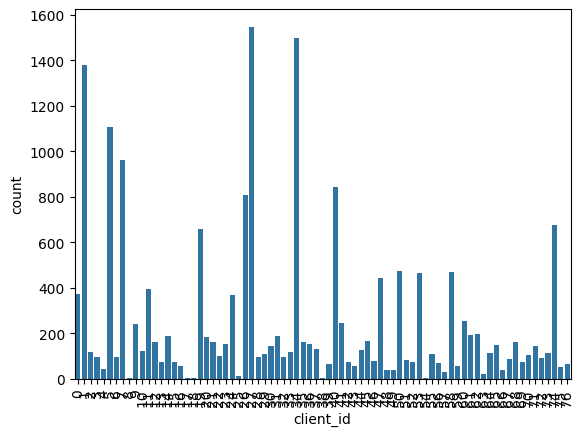

In [23]:
sns.countplot(x=dataframe["client_id"]) # plot the categories
plt.xticks(rotation=90);

# Extract audio feature


In [1]:
# columns = ["client", "gender", "mfccs", "stft", "chroma", "mel", "contrast", "tonnetz"]
columns_audio_pipeline = [
    "client",
    "gender",
    "mfcc1",
    "mfcc2",
    "mfcc3",
    "mfcc4",
    "mfcc5",
    "mfcc6",
    "mfcc7",
    "mfcc8",
    "mfcc9",
    "mfcc10",
    "mfcc11",
    "mfcc12",
    "mfcc13",
    "mfcc14",
    "mfcc15",
    "mfcc16",
    "mfcc17",
    "mfcc18",
    "mfcc19",
    "mfcc20",'zcr', 'spectral_c', 'rolloff'
]
features_df = pd.DataFrame(columns=columns_audio_pipeline)

print(len(dataframe))
print(dataframe)
for i in range(len(dataframe)):
    print(dataframe.loc[i])
    print(i, dataframe)
    features_df.loc[i] = audio_pipeline(dataframe.loc[i])

features_df

NameError: name 'pd' is not defined

In [81]:
labels = features_df['client']
features = features_df.drop('client', axis = 1)
print("feature to frame:", labels.to_frame())
labels.shape


feature to frame:       client
0        3.0
1       15.0
2       15.0
3       15.0
4       15.0
...      ...
2114     5.0
2115     5.0
2116     5.0
2117     5.0
2118     5.0

[2119 rows x 1 columns]


(2119,)

In [167]:
# split data to train and test data
from sklearn.model_selection import train_test_split

x = np.array(features, dtype = float)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1419, 24), (700, 24), (1419,), (700,))

In [195]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoder()
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
y_train = encoder.fit_transform(y_train)

x_test = scaler.fit_transform(x_test)
y_test = encoder.fit_transform(y_test)


x.shape, y.shape

x [[ 0.49498068  1.30143721 -0.00977135 ... -0.01871892 -0.55910303
  -0.68064044]
 [ 0.49498068  0.43959803  1.83790835 ...  0.08561398  0.12767151
  -0.05136658]
 [ 0.49498068 -0.26996182  0.67158003 ... -0.15623287  0.01694159
   0.11544282]
 ...
 [ 0.49498068  0.14641819  0.50631837 ... -0.47639132  0.67559172
  -0.56579413]
 [ 0.49498068  0.66534792  0.70701309 ... -0.80326072  0.42494584
  -0.98987278]
 [ 0.49498068  0.4546293   1.5342899  ... -0.39719246  0.59751542
  -0.37156475]]
y [ 3 15 15 ...  5  5  5]


((2119, 24), (2119,))

# Model function


In [196]:
from keras.models import Sequential
from keras.layers import Dense

def create_model():
    # création du modèle
    model = Sequential()
    model.add(Dense(25, input_shape=(25,), activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [222]:
print(len(new_client_id))

27


In [231]:
from tensorflow import keras
from keras.optimizers import Adam

# build model
model = keras.models.Sequential([
    keras.layers.Dense(64, activation = 'relu', input_shape = (x_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(27, activation = 'softmax'),
    
])
model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 64)                1600      
                                                                 
 dropout_73 (Dropout)        (None, 64)                0         
                                                                 
 dense_95 (Dense)            (None, 32)                2080      
                                                                 
 dense_96 (Dense)            (None, 27)                891       
                                                                 
Total params: 4571 (17.86 KB)
Trainable params: 4571 (17.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [232]:
y_test.shape = (y_test.shape[0], 1)
y_train.shape = (y_train.shape[0], 1)

print(y_train.shape)
print(y_test.shape)

print(x_train.shape, x_test.shape)
y_train

(1419, 1)
(700, 1)
(1419, 24) (700, 24)


array([[ 2],
       [ 4],
       [18],
       ...,
       [ 7],
       [ 8],
       [ 8]])

In [233]:

# compile model  
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics='accuracy')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics='accuracy')
# fit le modèles
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/10
12/12 [==============================] - 0s 11ms/step - loss: 3.2630 - accuracy: 0.0641 - val_loss: 3.4211 - val_accuracy: 0.0486
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 2.9817 - accuracy: 0.1663 - val_loss: 3.4505 - val_accuracy: 0.0829
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 2.7398 - accuracy: 0.3552 - val_loss: 3.5153 - val_accuracy: 0.0986
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 2.4802 - accuracy: 0.4623 - val_loss: 3.6191 - val_accuracy: 0.0971
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 2.2106 - accuracy: 0.5307 - val_loss: 3.7824 - val_accuracy: 0.0971
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 1.9449 - accuracy: 0.5793 - val_loss: 3.9992 - val_accuracy: 0.1014
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 1.6935 - accuracy: 0.6469 - val_loss: 4.2543 - val_accuracy: 0.1014
Epoch 8/10
12/12 [=

In [234]:
_, accuracy = model.evaluate(x_test, y_test, batch_size=128)

6/6 [==============================] - 0s 1ms/step - loss: 5.0787 - accuracy: 0.0957


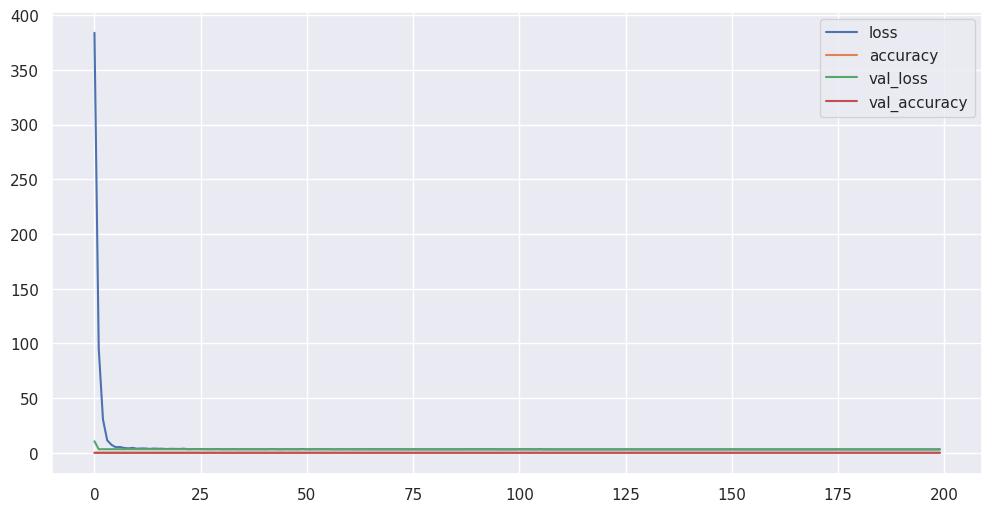

In [174]:
import matplotlib.pyplot as plt
# Plot results
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()


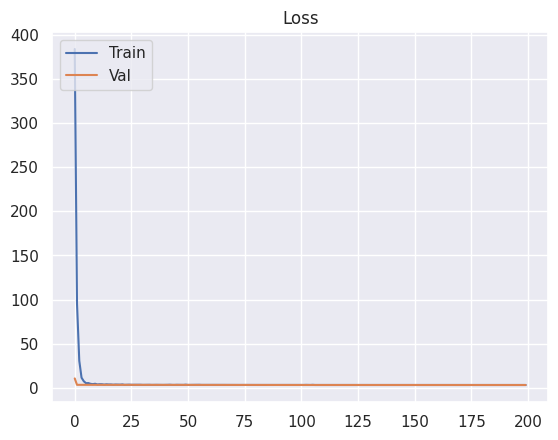

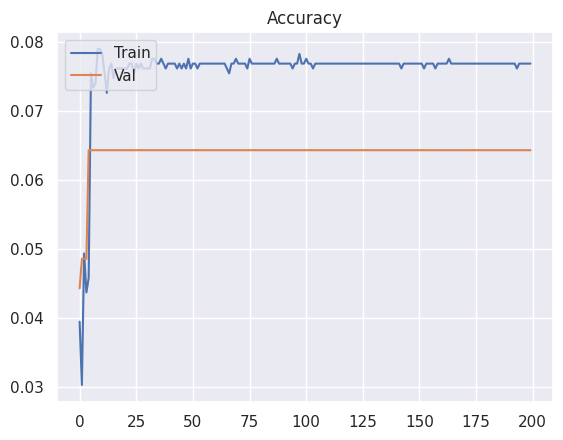

In [175]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [235]:
labels = np.array(labels[:])
print("labels:", labels, len(labels))

print("features:")
print(x_test)

labels: [ 3. 15. 15. ...  5.  5.  5.] 2119
features:
[[ 0.52001675  1.15820146  0.95226443 ...  0.64498342 -0.50275074
   0.75300539]
 [-1.92301497  1.44651288  0.57730326 ... -0.0064582  -3.25296592
  -2.07751726]
 [ 0.52001675 -0.75218698 -1.41035998 ... -1.6687371   0.97915549
  -1.57283967]
 ...
 [ 0.52001675  1.72331924  0.22445492 ... -1.26914999  1.1282647
   0.24521187]
 [ 0.52001675  0.66526427 -0.18430357 ... -0.26805238  1.1217674
  -0.13779237]
 [ 0.52001675 -0.48866623 -0.61121065 ...  0.95115159  1.74371692
   1.03528637]]


In [243]:

print(len(new_client_id))
print(len(x_train))
print(len(x_test))

27
1419
700


In [242]:
from sklearn.metrics import confusion_matrix 

sns.set()
predictions = model.predict(x_test)

genres = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
probs = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)

predicted_classes = np.argmax(probs, axis=1)
predicted_class_names = [genres[class_index] for class_index in predicted_classes]


for i in range(len(predicted_class_names)):
    print(f"Prédiction pour la musique {i + 1}: {predicted_class_names[i]}")



22/22 [==============================] - 0s 648us/step
Prédiction pour la musique 1: 21
Prédiction pour la musique 2: 18
Prédiction pour la musique 3: 8
Prédiction pour la musique 4: 8
Prédiction pour la musique 5: 11
Prédiction pour la musique 6: 26
Prédiction pour la musique 7: 26
Prédiction pour la musique 8: 2
Prédiction pour la musique 9: 10
Prédiction pour la musique 10: 10
Prédiction pour la musique 11: 8
Prédiction pour la musique 12: 0
Prédiction pour la musique 13: 6
Prédiction pour la musique 14: 24
Prédiction pour la musique 15: 17
Prédiction pour la musique 16: 26
Prédiction pour la musique 17: 4
Prédiction pour la musique 18: 26
Prédiction pour la musique 19: 18
Prédiction pour la musique 20: 21
Prédiction pour la musique 21: 18
Prédiction pour la musique 22: 21
Prédiction pour la musique 23: 2
Prédiction pour la musique 24: 6
Prédiction pour la musique 25: 2
Prédiction pour la musique 26: 17
Prédiction pour la musique 27: 21
Prédiction pour la musique 28: 8
Prédiction po

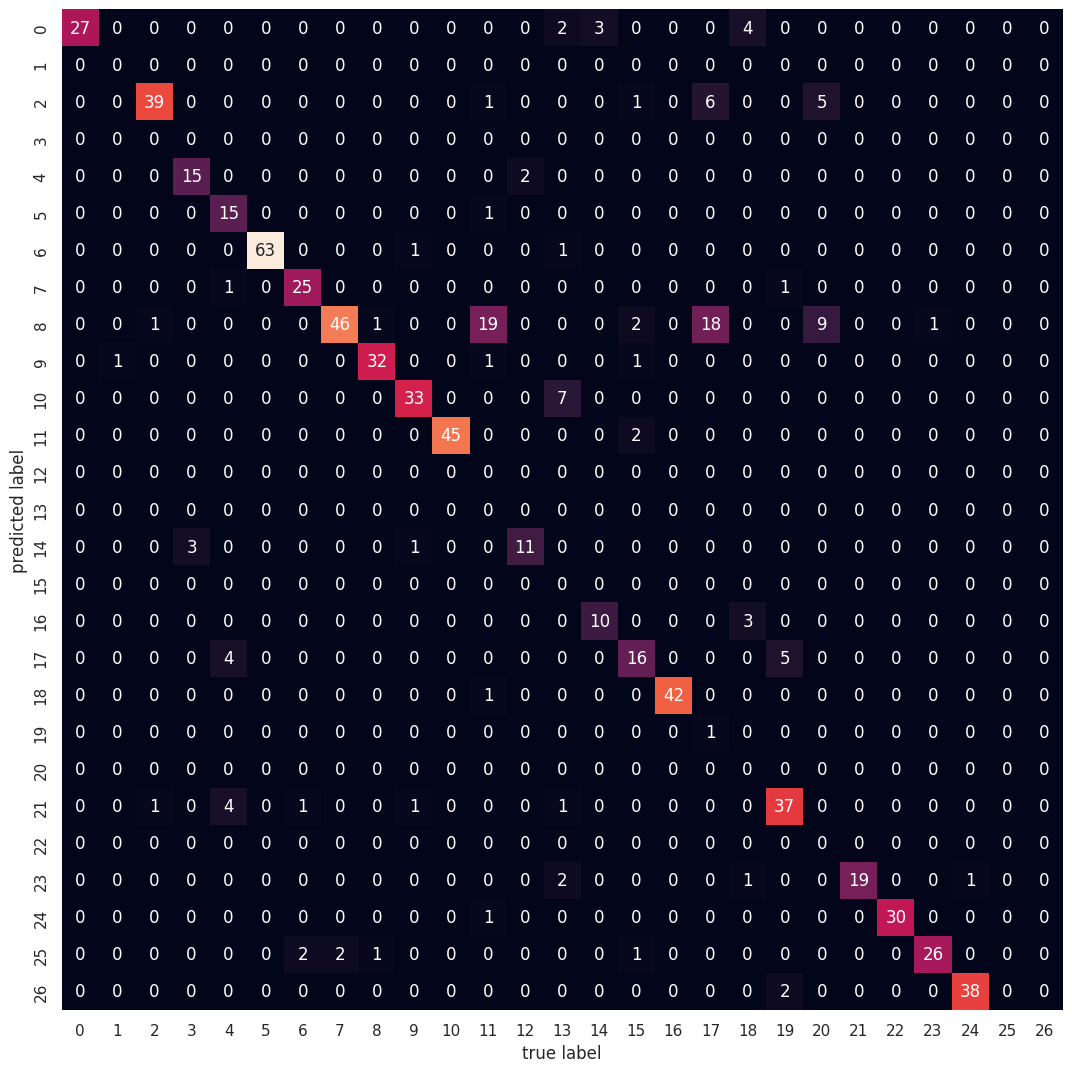

In [239]:
mat = confusion_matrix(y_test, np.argmax(predictions, 1))
plt.figure(figsize=(15, 13))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=new_client_id, yticklabels=new_client_id)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [238]:
print(predictions[1], len(predictions[1]))
print(len(y_test))

[4.2633479e-03 1.5289540e-04 2.1349671e-01 2.8632590e-04 5.4368237e-03
 9.6907787e-02 6.2911421e-02 6.0279286e-03 6.2757789e-04 2.0845300e-02
 3.4666839e-03 1.5285307e-03 1.1416325e-04 2.2834553e-03 2.1762408e-03
 8.0758001e-04 1.1253268e-03 6.8617746e-02 3.6067858e-01 8.6186896e-04
 1.7995496e-04 2.8530896e-02 2.9765815e-03 1.5202601e-04 1.0276118e-01
 2.8722968e-03 9.9107390e-03] 27
700
